# Zendesk Support Challenge 

**Problem**: The VP of Customer Advocacy has asked our team to evaluate how well we have been
supporting our customers over the last few quarters, and to provide meaningful business
insights.

**Why is Customer Service matter to the business ?**: 
A successful customer service team can help attract new business, boost retention, and increase sales among our existing customer base. But it is also a high stakes game:
- 73 % of consumers will leave for a competitor after multiple poor interactions 
- more than half will bolt after a single bad experience, according to the Zendesk Customer Experience Trends Report 2023. 
- Make it two negative experiences, and 76 percent of customers are out the door.

## Evaluate how well we have been supporting our customers

**What makes an excellent customer service ?**

Good customer service means consistently meeting customers’ expectations. Great customer service is **quick, easy, personalized, and empathetic**. Companies that deliver excellent customer service take the time needed to understand the needs of their unique customer base.


**Important Segments**: Channel, Tier, Plan, Group


### CSAT 

### First Reply Time (FRT)

makes sense to segment by channel

### Ticket Resolution Time 



### Ticket Response Rate 




## Lines of Research 

1. Are we optimizing ticket assigning by priority ? by predicting ticket resolution time 
2. Are we maximizing performance on each channel ?
3. Are we performing well on all customer segments ?
4. How can we increase the ticket response rate ? 


## Model 


## Results 


## Limitations


Missing features that would be useful:
1. Ticket content -> correlated to resolution time
2. Ticket Product Area -> could indicate areas of the product that need improvement

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import randint

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

import re
import string

from scipy import stats
from scipy.stats import norm, skew #for some statistics

credentials = service_account.Credentials.from_service_account_file(
'/Users/joaolousada/Downloads/solar-vertex-380321-55f7948b7f6a.json') 

project_id = 'solar-vertex-380321'
client = bigquery.Client(credentials= credentials,project=project_id)

In [3]:
import pandas_gbq

sql = """
SELECT *
FROM solar-vertex-380321.zendesk.zentest
"""
df_raw = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|██████████|


In [28]:
df = df_raw.copy()
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
0,938,chat,Support (T1),2536525,2017-04-20,Enterprise Legacy,None,Tier 1,317,<NA>,11,15,0,<NA>,2014-11-10,Dublin,Employee,892
1,938,chat,Support (T1),2522091,2017-04-14,Enterprise Legacy,None,Tier 1,10260,<NA>,14,22,0,<NA>,2014-11-10,Dublin,Employee,886
2,1247,web,Support (T1),2836287,2017-08-03,Enterprise Legacy,None,Tier 1,<NA>,<NA>,4,<NA>,0,<NA>,2015-04-20,Dublin,Employee,836
3,919,help_center,Support (T1),3003180,2017-10-02,Enterprise Legacy,None,Tier 1,<NA>,<NA>,3,1,0,<NA>,2014-10-27,Madison,Employee,1071
4,919,help_center,Support (T1),3003011,2017-10-02,Enterprise Legacy,None,Tier 1,<NA>,<NA>,3,1,0,<NA>,2014-10-27,Madison,Employee,1071


In [29]:
df.describe()

,EmployeeID,TicketID,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerTenure
count,240665.000000,2.406650e+05,157169.000000,239741.000000,195237.000000,192623.000000,240665.000000,45554.000000,240665.000000
mean,1853.958444,2.612557e+06,813.261088,5949.678053,3.100309,3.834443,0.159300,0.939500,514.366223
std,651.379958,2.820156e+05,6446.203622,19227.491206,3.499996,4.566357,0.365957,0.238413,353.778344
min,1.000000,2.116910e+06,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-223.000000
25%,1488.000000,2.340143e+06,14.000000,13.000000,1.000000,2.000000,0.000000,1.000000,262.000000
50%,1975.000000,2.629618e+06,53.000000,116.000000,2.000000,2.000000,0.000000,1.000000,469.000000
75%,2362.000000,2.849437e+06,236.000000,8112.000000,4.000000,4.000000,0.000000,1.000000,675.000000
max,3411.000000,3.224171e+06,498116.000000,548814.000000,370.000000,245.000000,1.000000,1.000000,2334.000000


Duplicates


In [30]:
print(f'Number of duplicates - {df[df.duplicated()].nunique().sum()}')

Number of duplicates - 0


Missing Values

In [31]:
missing = df.isnull().sum()
missing = 100*missing[missing > 0]/df.shape[0]
missing.sort_values(inplace=True)
missing
#plt.savefig('images/MV.eps', format='eps', transparent = True)

DayTicketSolved          0.383936
FullResolutionTime       0.383936
AssigneeTier            13.568654
NumAgentComments        18.876031
NumPublicComments       19.962188
ZendeskPlan             26.150874
FirstReplyTime          34.693869
CustomerSatisfaction    81.071614
dtype: float64

In [32]:
for col in ('AssigneeTier', 'ZendeskPlan'):
    df[col] = df[col].fillna('None')

for col in ('NumPublicComments', 'NumAgentComments'):
    df[col] = df[col].fillna(0)

df['FirstReplyTime'] = df['FirstReplyTime'].fillna(0)

# Drop open tickets
df = df.dropna(subset=['FullResolutionTime', 'DayTicketSolved'])

df["CustomerSatisfaction"] = df["CustomerSatisfaction"].replace({0: -1}).fillna(0)

In [33]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,-1,2014-06-01,Manila,Employee,962
925,1463,chat,Zopim T1,2132608,2017-01-06,None,Friday,None,0,4,0,0,0,0,2015-08-03,Manila,Employee,522
926,1463,chat,Zopim T1,2132014,2017-01-06,None,Friday,None,0,35,0,0,0,0,2015-08-03,Manila,Employee,522
927,1463,chat,Zopim T1,2878472,2017-08-18,None,Friday,None,0,0,0,0,0,0,2015-08-03,Manila,Employee,746
928,1463,chat,Zopim T1,2483674,2017-03-31,None,Friday,None,0,2,0,0,0,0,2015-08-03,Manila,Employee,606


## EDA 


ValueError: could not convert string to float: '>5Days'

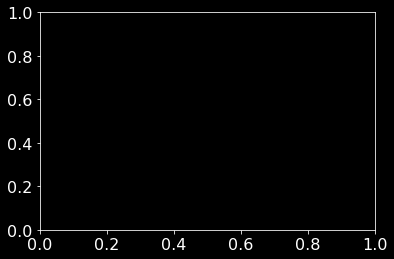

In [227]:
target = df['FullResolutionTime'].dropna()

sns.distplot(target , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ResolutionTime distribution')



In [45]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

AttributeError: 'float' object has no attribute 'shape'

<Figure size 432x288 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x14db2afb0>,
 'caps': [<matplotlib.lines.Line2D at 0x14db2b550>,
 'boxes': [<matplotlib.lines.Line2D at 0x14db2ae00>],
 'medians': [<matplotlib.lines.Line2D at 0x14db2baf0>],
 'fliers': [],
 'means': []}

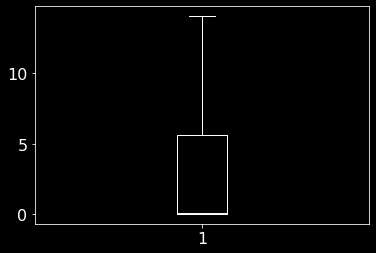

In [200]:
plt.boxplot(target, showfliers=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x1405c5870>,
 'caps': [<matplotlib.lines.Line2D at 0x1405c5e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1405c55a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1405c63b0>],
 'fliers': [],
 'means': []}

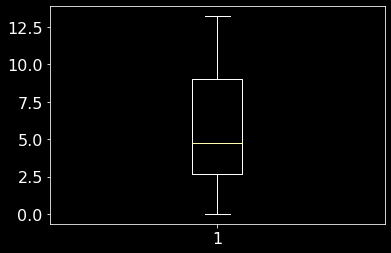

In [42]:
plt.boxplot(np.log1p(target), showfliers=False)

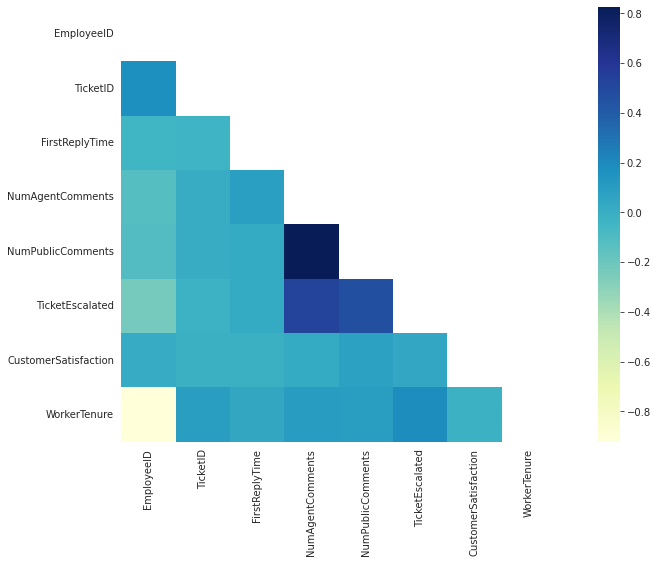

In [228]:
# Get correlations for the dataset loaded as df
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

test_correlations = df.corr();
plt.figure(figsize=(15, 8))
mask = np.zeros_like(test_correlations)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
 ax = sns.heatmap(test_correlations, mask=mask, square=True, xticklabels=True, yticklabels=True, cmap='YlGnBu')

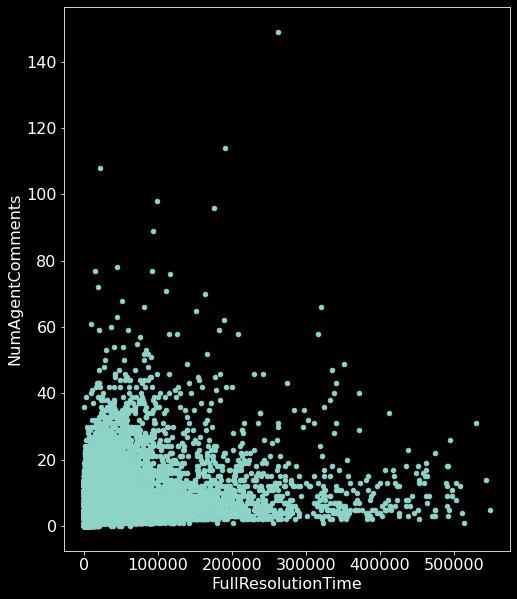

In [90]:
ax1 = df.plot.scatter(x='FullResolutionTime',y='NumAgentComments')

<function matplotlib.pyplot.show(close=None, block=None)>

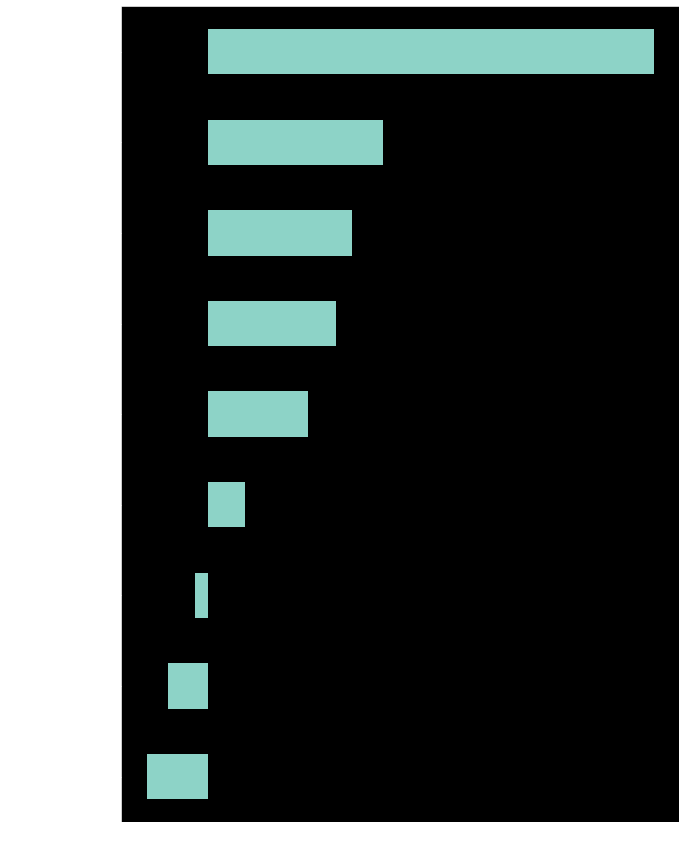

In [ ]:
cat_columns = df.select_dtypes(['category']).columns
df_corr = df.copy()
df_corr[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

corr_matrix = df_corr.corr()
f, ax = plt.subplots(figsize=(10,15))
corr_matrix['FullResolutionTime'].sort_values(ascending=True).plot.barh()
plt.show

In [647]:
df['TicketCreatedDate'] = pd.to_datetime(df['TicketCreatedDate'])
df['TicketCreatedYear'] = df['TicketCreatedDate'].dt.isocalendar().year
df['TicketCreatedWeekNr'] = df['TicketCreatedDate'].dt.isocalendar().week

In [650]:
df['TicketClosedDate'] = pd.to_datetime((df['TicketCreatedDate'] + pd.to_timedelta(df['FullResolutionTime'], unit='min')).dt.date)
df['SolvedSameDay'] = df['TicketCreatedDate'] == df['TicketClosedDate']
print(df[['TicketCreatedDate','TicketClosedDate']])

       TicketCreatedDate TicketClosedDate
924           2017-01-18       2017-01-27
925           2017-01-06       2017-01-06
926           2017-01-06       2017-01-06
927           2017-08-18       2017-08-18
928           2017-03-31       2017-03-31
...                  ...              ...
240660        2017-07-17       2017-07-19
240661        2017-05-22       2017-06-14
240662        2017-06-27       2017-07-04
240663        2017-07-05       2017-07-18
240664        2017-04-21       2017-05-09

[239741 rows x 2 columns]


<AxesSubplot:xlabel='TicketCreatedYear,TicketCreatedWeekNr'>

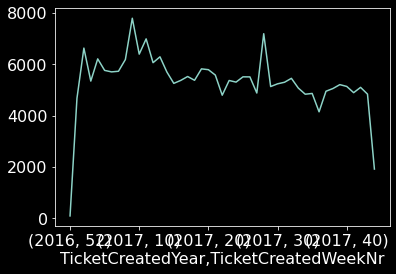

In [74]:
# Volume of tickets Overtime

df.groupby(['TicketCreatedYear','TicketCreatedWeekNr'])['TicketID'].count().plot.line()

<AxesSubplot:xlabel='TicketCreatedYear,TicketCreatedWeekNr'>

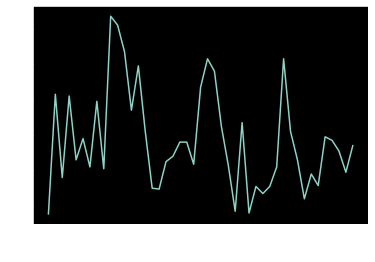

In [ ]:
# time to solve tickets

df.groupby(['TicketCreatedYear','TicketCreatedWeekNr'])['FullResolutionTime'].median().plot.line()

<AxesSubplot:>

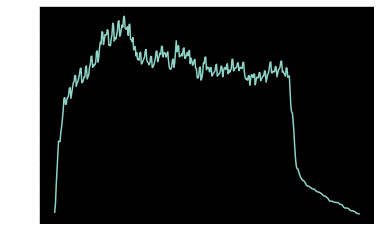

In [ ]:
# daily ticket queue

def queue_size(date): 
    mask = (date >= df['TicketCreatedDate']) & (date < df['TicketResolutionDate'])
    return df.loc[mask]['TicketID'].count()

ts=pd.Series(pd.date_range(start=df['TicketCreatedDate'].min(), end=df['TicketResolutionDate'].max()))
ts.apply (lambda row: queue_size(row)).plot.line()


In [ ]:
def f(x):
    d = {}
    d['volume'] = x['TicketID'].count()
    d['response_rate'] = round(100*x[x['CustomerSatisfaction'] != None]['TicketID'].count() / x['TicketID'].count(), 2)
    d['csat_score'] = round(100*x['CustomerSatisfaction'].sum()/x[x['CustomerSatisfaction'] != None]['TicketID'].count() , 2)
    return pd.Series(d, index=['volume', 'response_rate', 'csat_score'])

df.groupby('ZendeskPlan').apply(f).sort_values( by='volume', ascending=False)

,volume,response_rate,csat_score
ZendeskPlan,,,
None,62776.0,14.16,89.04
Enterprise Legacy,44452.0,22.78,96.11
Trial,33322.0,21.70,95.28
Professional,22866.0,22.37,94.76
Plus,18383.0,24.13,95.22
Non-Customer,12839.0,1.85,79.75
Team,11734.0,20.58,94.24
Expired,11210.0,21.09,94.63
Enterprise,7052.0,24.73,95.87


<AxesSubplot:>

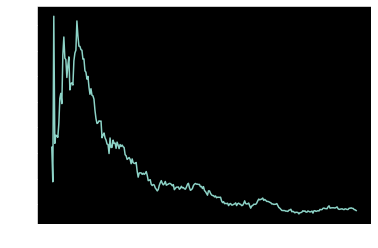

In [ ]:
# CSAT Over time 

def csat(date): 
    mask = (date >= df['TicketCreatedDate']) & (df['CustomerSatisfaction'] != None)
    return 100*df.loc[mask]['CustomerSatisfaction'].sum()/df.loc[mask]['TicketID'].count()

ts=pd.Series(pd.date_range(start=df['TicketCreatedDate'].min(), end=df['TicketCreatedDate'].max()))
ts.apply (lambda row: csat(row)).plot.line()


<AxesSubplot:xlabel='TicketCreatedYear,TicketCreatedWeekNr'>

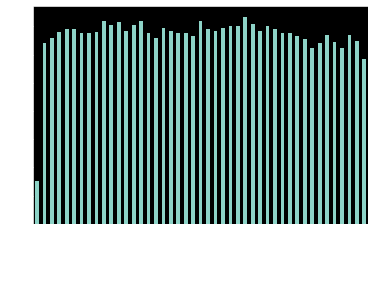

In [ ]:
# Weekly Active Employees 
df.groupby(['TicketCreatedYear','TicketCreatedWeekNr'])['EmployeeID'].nunique().plot.bar()

In [ ]:
# Ticket Info 
q1 = f'how many tickets were created ?\n'
a1 = df['TicketID'].nunique()
print(q1,a1)

q2 = f'--- \nhow % of tickets were solved ?\n'
a2 = df['FullResolutionTime'].count()
print(q2,np.round(100*a2/a1, 2))

q3 = f'--- \nhow long does it take to solve a ticket ?\n'
print(q3, df['FullResolutionTime'].describe())

q4 = f'--- \nWhat channels receive more tickets ?\n'
print(q4, df.groupby(['TicketChannel'])['TicketID'] \
    .count() \
    .reset_index(name='count') \
    .sort_values(['count'], ascending=False)
)



how many tickets were created ?
 239741
--- 
how % of tickets were solved ?
 100.0
--- 
how long does it take to solve a ticket ?
 count    239741.000000
mean       5949.678053
std       19227.491206
min           0.000000
25%          13.000000
50%         116.000000
75%        8112.000000
max      548814.000000
Name: FullResolutionTime, dtype: float64
--- 
What channels receive more tickets ?
   TicketChannel  count
1          chat  87874
8           web  66105
2         email  44627
7         voice  32886
0           api   4752
6       twitter   2039
3      facebook    819
4   help_center    630
5        mobile      9


In [ ]:
# average tickets solved per day per employee

df.groupby(['EmployeeID']).agg({'TicketID':['count'], 
                         'FullResolutionTime':['count','median', 'mean'],
                         'FirstReplyTime': ['count', 'median'],
                         'NumAgentComments': 'median',
                         'NumPublicComments': 'median',
                         'TicketEscalated': 'sum',
                         'CustomerSatisfaction': 'sum'
                         }).sort_values(by=('CustomerSatisfaction','sum'), ascending=False)


TicketID FullResolutionTime                       FirstReplyTime  \
              count              count   median         mean          count   
EmployeeID                                                                    
2081          14040              14040      5.0   166.566453          14040   
2050           7828               7828      9.0    322.87187           7828   
1463           7676               7676      6.0   250.369724           7676   
2031           3568               3568   1608.0  6750.746357           3568   
2149           4675               4675     60.0  4807.848342           4675   
...             ...                ...      ...          ...            ...   
1077              2                  2    191.0        191.0              2   
939               6                  6    468.5  3249.166667              6   
411               5                  5     12.0      23569.2              5   
528               1                  1  22723.0      22723.0              1   
553               1                  1     78.0         78.0              1   

                   NumAgentComments NumPublicComments TicketEscalated  \
            median           median            median             sum   
EmployeeID                                                              
2081          -1.0              0.0               0.0             254   
2050          -1.0              0.0               0.0             140   
1463          -1.0              0.0               0.0             100   
2031          46.5              2.0               2.0              55   
2149          16.0              2.0               2.0              74   
...            ...              ...               ...             ...   
1077          23.5              1.5               3.0               1   
939            5.5              2.0               3.0               1   
411           -1.0              2.0               0.0               0   
528         4257.0              4.0               3.0               1   
553           78.0              3.0               2.0               0   

           CustomerSatisfaction  
                            sum  
EmployeeID                       
2081                       1960  
2050                       1262  
1463                       1073  
2031                        767  
2149                        741  
...                         ...  
1077                          0  
939                           0  
411                           0  
528                           0  
553                           0  

[193 rows x 10 columns]

In [275]:
corr_matrix = df.corr()
corr_matrix['FullResolutionTime'].sort_values(ascending=False)

KeyError: 'FullResolutionTime'

## Preprocessing

In [7]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,-1,2014-06-01,Manila,Employee,962
925,1463,chat,Zopim T1,2132608,2017-01-06,None,Friday,None,0,4,0,0,0,0,2015-08-03,Manila,Employee,522
926,1463,chat,Zopim T1,2132014,2017-01-06,None,Friday,None,0,35,0,0,0,0,2015-08-03,Manila,Employee,522
927,1463,chat,Zopim T1,2878472,2017-08-18,None,Friday,None,0,0,0,0,0,0,2015-08-03,Manila,Employee,746
928,1463,chat,Zopim T1,2483674,2017-03-31,None,Friday,None,0,2,0,0,0,0,2015-08-03,Manila,Employee,606


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239741 entries, 924 to 240664
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   EmployeeID            239741 non-null  Int64 
 1   TicketChannel         239741 non-null  object
 2   TicketGroup           239741 non-null  object
 3   TicketID              239741 non-null  Int64 
 4   TicketCreatedDate     239741 non-null  dbdate
 5   ZendeskPlan           239741 non-null  object
 6   DayTicketSolved       239741 non-null  object
 7   AssigneeTier          239741 non-null  object
 8   FirstReplyTime        239741 non-null  Int64 
 9   FullResolutionTime    239741 non-null  Int64 
 10  NumAgentComments      239741 non-null  Int64 
 11  NumPublicComments     239741 non-null  Int64 
 12  TicketEscalated       239741 non-null  Int64 
 13  CustomerSatisfaction  239741 non-null  Int64 
 14  WorkerDateHired       239741 non-null  dbdate
 15  WorkerLocation 

In [35]:
df['TicketClosedDate'] = pd.to_datetime((pd.to_datetime(df['TicketCreatedDate']) + pd.to_timedelta(df['FullResolutionTime'], unit='m')).dt.date)
df['TicketCreatedDate'] = pd.to_datetime(df['TicketCreatedDate'])


In [38]:
def queue_size(eID, date): 
    mask = (date >= df['TicketCreatedDate']) & (date < df['TicketClosedDate'])
    return df[df['EmployeeID'] == eID].loc[mask]['TicketID'].count()

ts = pd.date_range(start=df['TicketCreatedDate'].min(), end=df['TicketClosedDate'].max())
eID = (list(df['EmployeeID'].unique()))

multi_index = pd.MultiIndex.from_product([eID,ts], names=["EmployeeID", "Date"]).to_frame()
multi_index.reset_index(drop=True, inplace=True)

# iterate through employees
multi_index['QueueSize'] = multi_index.apply(lambda x: queue_size(x['EmployeeID'], x['Date']), axis=1)
multi_index.set_index(['EmployeeID','Date'], inplace=True)
multi_index.head()


QueueSize
EmployeeID Date                 
688        2017-01-01          0
           2017-01-02          0
           2017-01-03          0
           2017-01-04          0
           2017-01-05          2

In [39]:
df['NrOpenTickets'] = df.apply(lambda x: multi_index.loc[x['EmployeeID'], x['TicketCreatedDate']], axis=1)

In [40]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure,TicketClosedDate,NrOpenTickets
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,-1,2014-06-01,Manila,Employee,962,2017-01-27,4
925,1463,chat,Zopim T1,2132608,2017-01-06,None,Friday,None,0,4,0,0,0,0,2015-08-03,Manila,Employee,522,2017-01-06,2
926,1463,chat,Zopim T1,2132014,2017-01-06,None,Friday,None,0,35,0,0,0,0,2015-08-03,Manila,Employee,522,2017-01-06,2
927,1463,chat,Zopim T1,2878472,2017-08-18,None,Friday,None,0,0,0,0,0,0,2015-08-03,Manila,Employee,746,2017-08-18,3
928,1463,chat,Zopim T1,2483674,2017-03-31,None,Friday,None,0,2,0,0,0,0,2015-08-03,Manila,Employee,606,2017-03-31,0


In [43]:
df.set_index('TicketID')

df['TicketCreatedMonth'] = pd.DatetimeIndex(df['TicketCreatedDate']).month
df['HasResponded'] = df.apply(lambda x: 0 if x['CustomerSatisfaction'] == 0 else 1, axis=1)
di = {'None': 0, 'Triage': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 1': 3}
df.replace({"AssigneeTier": di}, inplace=True)

exclude = [
    'TicketID',
    'WorkerDateHired',
    'TicketCreatedDate',
    'TicketClosedDate',
    'CustomerSatisfaction'
]

df = df.drop(exclude, axis=1)

df.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,WorkerLocation,Worker_Type,WorkerTenure,NrOpenTickets,TicketCreatedMonth,HasResponded
924,688,chat,Zopim T1,None,Friday,0,0,13309,1,0,0,Manila,Employee,962,4,1,1
925,1463,chat,Zopim T1,None,Friday,0,0,4,0,0,0,Manila,Employee,522,2,1,0
926,1463,chat,Zopim T1,None,Friday,0,0,35,0,0,0,Manila,Employee,522,2,1,0
927,1463,chat,Zopim T1,None,Friday,0,0,0,0,0,0,Manila,Employee,746,3,8,0
928,1463,chat,Zopim T1,None,Friday,0,0,2,0,0,0,Manila,Employee,606,0,3,0


In [44]:
from sklearn.preprocessing import LabelEncoder

df_cat = list(df.select_dtypes(include=object))

# process columns, apply LabelEncoder to categorical features
for c in df_cat:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

df.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,WorkerLocation,Worker_Type,WorkerTenure,NrOpenTickets,TicketCreatedMonth,HasResponded
924,688,1,26,7,0,0,0,13309,1,0,0,5,1,962,4,1,1
925,1463,1,26,7,0,0,0,4,0,0,0,5,1,522,2,1,0
926,1463,1,26,7,0,0,0,35,0,0,0,5,1,522,2,1,0
927,1463,1,26,7,0,0,0,0,0,0,0,5,1,746,3,8,0
928,1463,1,26,7,0,0,0,2,0,0,0,5,1,606,0,3,0


In [46]:
df['FullResolutionTime'] = np.log1p(df['FullResolutionTime'])
df['FirstReplyTime'] = np.log1p(df['FirstReplyTime'])
df['Workload'] = df['AssigneeTier'] * df['NrOpenTickets']

In [47]:
corr_matrix = df.corr()
corr_matrix['HasResponded'].sort_values(ascending=False)

HasResponded          1.000000
FirstReplyTime        0.110874
NumPublicComments     0.102774
FullResolutionTime    0.076653
TicketEscalated       0.048041
AssigneeTier          0.044628
NumAgentComments      0.039447
Workload              0.034932
DayTicketSolved       0.024282
NrOpenTickets         0.021635
Worker_Type           0.018216
EmployeeID            0.018010
WorkerLocation        0.001617
ZendeskPlan          -0.002272
TicketCreatedMonth   -0.006962
WorkerTenure         -0.020241
TicketGroup          -0.025120
TicketChannel        -0.032974
Name: HasResponded, dtype: float64

In [88]:
corr_matrix['FullResolutionTime'].sort_values(ascending=False)

FullResolutionTime    1.000000
FirstReplyTime        0.670031
NumPublicComments     0.506921
NumAgentComments      0.459622
TicketEscalated       0.373763
NrOpenTickets         0.339590
Workload              0.333038
AssigneeTier          0.289325
TicketChannel         0.260109
HasResponded          0.076653
WorkerLocation        0.053964
WorkerTenure          0.051527
DayTicketSolved      -0.010984
Worker_Type          -0.014857
TicketCreatedMonth   -0.016388
ZendeskPlan          -0.037085
EmployeeID           -0.049360
TicketGroup          -0.188790
Name: FullResolutionTime, dtype: float64

In [89]:
included = ['TicketChannel', 'FirstReplyTime','TicketGroup', 'Workload', 'FullResolutionTime']

df_new = df[included]

In [90]:
df_new.head()

,TicketChannel,FirstReplyTime,TicketGroup,Workload,FullResolutionTime
924,1,0.0,26,0,9.496271
925,1,0.0,26,0,1.609438
926,1,0.0,26,0,3.583519
927,1,0.0,26,0,0.0
928,1,0.0,26,0,1.098612


## Regression 



In [91]:
from sklearn.metrics import mean_squared_error,roc_auc_score, auc, roc_curve, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
import optuna

cv = KFold(n_splits=4)

In [92]:
df_model = df_new.copy()

y = df_model.pop('FullResolutionTime')
X = df_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Linear Regression

In [93]:
from sklearn.linear_model import LinearRegression, LassoCV

model = LinearRegression()
score = cross_val_score(
     model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

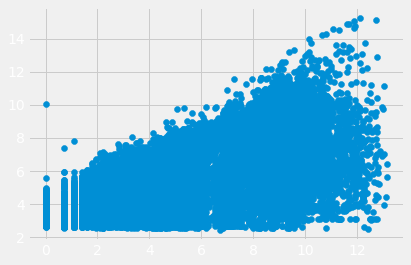

In [94]:
plt.scatter(y_test, (y_pred))

MSE of rf on test set: 5.33
R2 of rf on test set: 0.48


(array([1.0000e+00, 2.0000e+00, 1.7500e+02, 1.0233e+04, 1.5209e+04,
        1.1611e+04, 7.9930e+03, 2.3530e+03, 3.3100e+02, 4.1000e+01]),
 array([-10.027538741371911, -8.033244265284084, -6.0389497891962565,
        -4.044655313108429, -2.0503608370206017, -0.05606636093277473,
        1.938228115155054, 3.932522591242881, 5.926817067330708,
        7.921111543418535, 9.915406019506362], dtype=object),
 <BarContainer object of 10 artists>)

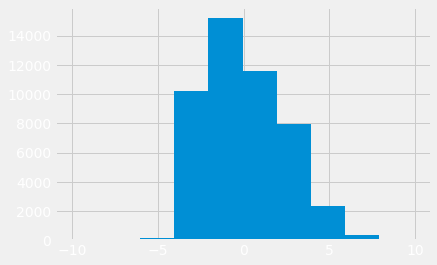

In [95]:
print('MSE of rf on test set: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred)

<AxesSubplot:xlabel='preds', ylabel='residuals'>

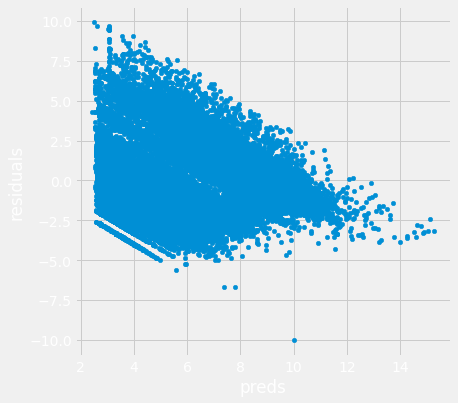

In [96]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": y_pred, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Lasso


In [481]:
model = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
score = cross_val_score(
     model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
print(score)

model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test)

-2.510805302818416


RMSE of rf on test set: 6.29
R2 of rf on test set: 0.38


(array([1.0000e+00, 1.0000e+00, 3.0000e+00, 7.0000e+00, 1.4000e+01,
        1.1100e+02, 1.4102e+04, 2.3372e+04, 1.0141e+04, 1.9700e+02]),
 array([-28.9670582951032, -25.058655723554015, -21.15025315200483,
        -17.241850580455647, -13.333448008906462, -9.425045437357277,
        -5.516642865808095, -1.6082402942589091, 2.3001622772902763,
        6.208564848839458, 10.116967420388647], dtype=object),
 <BarContainer object of 10 artists>)

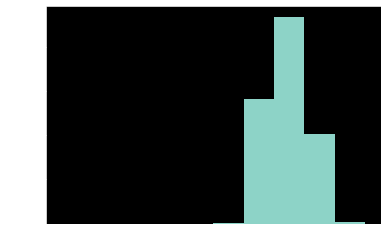

In [482]:
print('RMSE of rf on test set: {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred)


In [472]:
coef = pd.Series(model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 6 variables and eliminated the other 0 variables


In [473]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

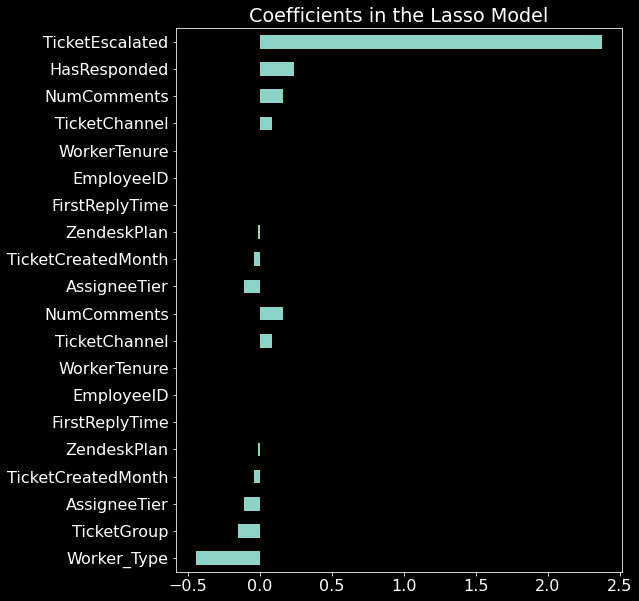

In [148]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Random Forest Regression

In [97]:
def objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 12)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 8)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 6)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestRegressor(
     max_depth=_max_depth,
     min_samples_split=_min_samp_split,
     min_samples_leaf=_min_samples_leaf,
     max_features=_max_features,
     n_estimators=_n_estimators,
     n_jobs=-1,
     random_state=42,
    )

    score = cross_val_score(
     rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

rf_params = study.best_params
rf_best_score = study.best_value
print(f"Best score:{rf_best_score} \nOptimized parameters: {rf_params}")

[W 2023-03-25 01:36:49,631] Trial 1 failed with parameters: {'n_estimators': 131, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 24} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/nz/_1_4r28n6sd_j7432npcb9j40000gn/T/ipykernel_1252/1105638951.py", line 18, in objective
    score = cross_val_score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/Library/Frameworks/Python.framework/Versions/3.10/li

KeyboardInterrupt: 

In [98]:
rf_params = {
    'max_depth': 10, 
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': 27,
    "n_estimators": 122
}

In [99]:
rf = RandomForestRegressor(**rf_params)

stack_scores = cross_val_score(
    rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)

rf.fit(X_train.values, y_train.values)
y_pred = rf.predict(X_test)

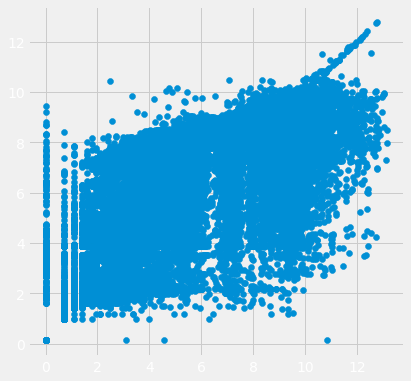

In [100]:
plt.scatter(y_test, (y_pred))

RMSE of rf on test set: 1.90
R2 of rf on test set: 0.65


(array([2.0000e+01, 8.9000e+01, 1.4400e+03, 8.4520e+03, 2.1124e+04,
        1.3010e+04, 2.9190e+03, 8.1000e+02, 8.2000e+01, 3.0000e+00]),
 array([-9.44589054691626, -7.431348890759546, -5.416807234602833,
        -3.4022655784461193, -1.387723922289405, 0.6268177338673091,
        2.6413593900240215, 4.655901046180736, 6.67044270233745,
        8.684984358494162, 10.699526014650878], dtype=object),
 <BarContainer object of 10 artists>)

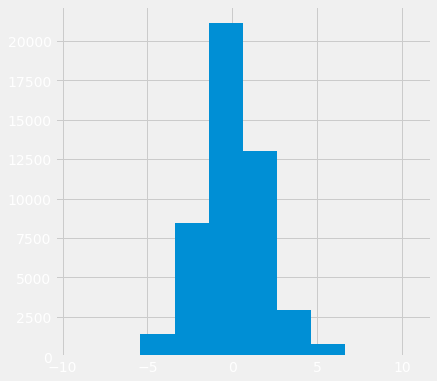

In [101]:
print('RMSE of rf on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred) 

<AxesSubplot:xlabel='preds', ylabel='residuals'>

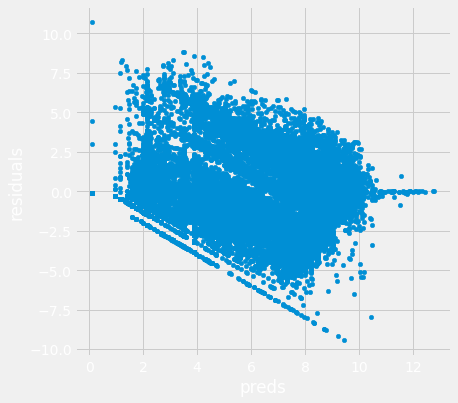

In [102]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": y_pred, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Classification

In [49]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,WorkerLocation,Worker_Type,WorkerTenure,NrOpenTickets,TicketCreatedMonth,HasResponded,Workload
924,688,1,26,7,0,0,0.0,9.496271,1,0,0,5,1,962,4,1,1,0
925,1463,1,26,7,0,0,0.0,1.609438,0,0,0,5,1,522,2,1,0,0
926,1463,1,26,7,0,0,0.0,3.583519,0,0,0,5,1,522,2,1,0,0
927,1463,1,26,7,0,0,0.0,0.0,0,0,0,5,1,746,3,8,0,0
928,1463,1,26,7,0,0,0.0,1.098612,0,0,0,5,1,606,0,3,0,0


In [68]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import optuna

cv = KFold(n_splits=4)

In [65]:
df_model = df.copy()

y = df_model.pop('HasResponded')
X = df_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Random under-sampling:
0    155283
1     36509
Name: HasResponded, dtype: int64


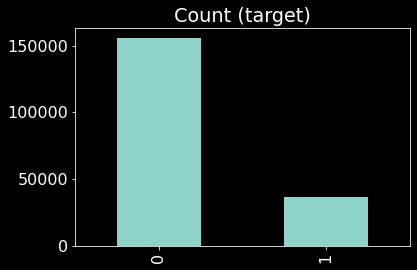

In [59]:
print('Random under-sampling:')
print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Count (target)');

Random under-sampling:
0    36509
1    36509
Name: HasResponded, dtype: int64


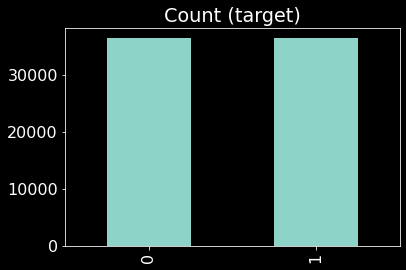

In [62]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train, y_train  = rus.fit_resample(X_train, y_train)

print('Random under-sampling:')
print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Count (target)');

In [63]:
def baseline(train, test, target, model): 
    cv = KFold(n_splits=5)
    
    # Data Normalization
    sc = StandardScaler()
    train = sc.fit_transform(train)
    test = sc.transform(test)

    score = cross_val_score(model, train, target, cv=cv, scoring="roc_auc")
    print('%.3f' % score.mean())

    model.fit(train, target)
    predictions = model.predict(test)

    return predictions

#### Dummy Classifier

In [75]:
dummy_clf = DummyClassifier(strategy="stratified")
y_pred = baseline(X_train, X_test, y_train, dummy_clf)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

0.501
[[31549  7355]
 [ 7258  1787]]
Precision: 0.195
Recall: 0.198
F1: 0.197
Accuracy: 0.695


In [71]:
lr = LogisticRegression(penalty='l2', class_weight='balanced')
y_pred = baseline(X_train, X_test, y_train, lr)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

0.630
[[23265 15639]
 [ 3643  5402]]
Precision: 0.257
Recall: 0.597
F1: 0.359
Accuracy: 0.598


In [55]:
rf = RandomForestClassifier()
y_pred = baseline(X_train, X_test, y_train, rf)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

0.688
[[37411  1493]
 [ 8175   870]]
Precision: 0.368
Recall: 0.096
F1: 0.153
Accuracy: 0.798


In [57]:
rf.feature_importances_

array([0.06870891, 0.02503742, 0.01992301, 0.05704075, 0.04992943,
       0.00593143, 0.10825788, 0.19826642, 0.03941673, 0.04626658,
       0.00506565, 0.02448688, 0.00025577, 0.12945473, 0.08457512,
       0.05985479, 0.07752849])

## Improvements

In [76]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [77]:
kmeans.fit(df)


KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [79]:
# The lowest SSE value
print(kmeans.inertia_)


# Final locations of the centroid
print(kmeans.cluster_centers_)


# The number of iterations required to converge
print(kmeans.n_iter_)

25798448040.741917
[[2.52789569e+03 4.32285270e+00 1.48339077e+01 7.24164503e+00
  3.28024658e+00 1.88557872e+00 3.14728869e+00 5.81706342e+00
  2.44919059e+00 2.99889571e+00 7.74215470e-02 4.05158605e+00
  1.00000000e+00 1.97226343e+02 2.76469068e+01 5.92516322e+00
  2.02339635e-01 5.20342087e+01]
 [8.57335880e+02 4.58798283e+00 1.79260730e+01 6.79783262e+00
  3.34221030e+00 1.43693133e+00 3.28831887e+00 6.32786035e+00
  3.48594421e+00 4.22929185e+00 3.22317597e-01 4.17437768e+00
  9.94141631e-01 1.04593464e+03 2.75736910e+01 5.13364807e+00
  1.86995708e-01 3.93903219e+01]
 [1.77542974e+03 3.46229286e+00 1.92264054e+01 7.05347903e+00
  3.29419786e+00 1.20087597e+00 2.30779210e+00 4.79374111e+00
  2.10095272e+00 2.57772159e+00 1.47442091e-01 4.06661850e+00
  9.97001851e-01 5.24487606e+02 1.94312006e+01 4.94204181e+00
  1.82110444e-01 2.96728857e+01]]
6


In [80]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

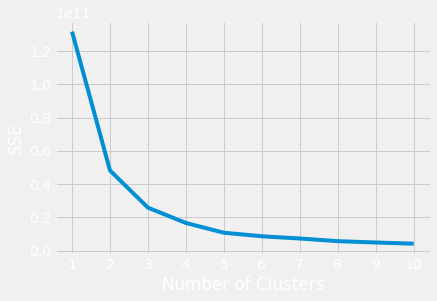

In [81]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [82]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [84]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

KeyboardInterrupt: 

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

features, true_labels = X_test, y_test

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(features)
dbscan.fit(features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    features, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
   features, dbscan.labels_
).round (2)